In [2]:
import os
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join as pjoin
from nod_utils import get_roi_data, ReceptiveFieldProcessor, save_ciftifile

# define plot utils
mpl.rcParams['axes.linewidth'] = 2
# mpl.rcParams.update({'font.size': 9, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'mathtext.fontset': 'stix'})

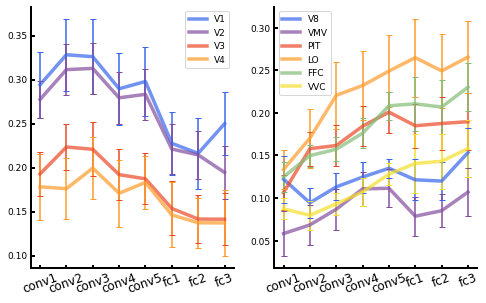

In [8]:
# ROI Acurary Across DNN Layers subject level
"""
extract_roi_performance support a threshold filter on quota
"""
def extract_roi_performance(sub_log, roi, quota=' lasso-test-cor'):
    '''return roi's mean std and number of voxels across layer'''
    if isinstance(roi, list):
        select_index = np.sum([(sub_log['roi'] == _).values for _ in roi], axis=0).astype(np.bool)
    else:
        select_index = (sub_log['roi'] == roi).values
    _df = sub_log.loc[select_index,:]
    # # filter
    # _df = _df.loc[_df[quota].values>0,:]
    desc_table = _df.groupby('layer')[quota].agg([np.mean, np.std])
    
    return desc_table['mean'].values, desc_table['std'].values, _df.shape[0]/8
# load record file
log_folder = './encoder_records'

load_sub = lambda x : pd.read_csv(pjoin(log_folder,f'{x}-hp128_s4_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))

subs = ['sub-01','sub-02','sub-03','sub-04','sub-05','sub-06','sub-07','sub-08','sub-09']
sub_logs = list(map(load_sub, subs))

# 
vtc_areas = ['V8','VMV', 'PIT','LO', 'FFC', 'VVC'] 
evc_areas = ['V1', 'V2', 'V3','V4']
roi_areas = [__  for _ in [evc_areas, vtc_areas] for __ in _]

#
fig, axs = plt.subplots(1, 2, figsize=(8,4.8))
i,j = 0,0
alpha = 0.7
lwidth = 2.5
quota_value = 'lasso-test-cor'
# colors = ['#E60965', '#FF8243', '#113CFC', '#610094',  '#83BD75', ]
colors = ['#3866ED','#824D9E','#EC4727', '#FE9B2A','#83BD75','#F5DF29','#D13655']
quota_value = 'lasso-test-cor'
error_denominator =  np.sqrt(len(sub_logs))
for _roi_ in roi_areas:
    means = []
    for sub_log in sub_logs:
        sub_log['cor_diff'] = sub_log['lasso-test-cor'] - sub_log['lr-test-cor']
        sub_log['r2_diff'] = sub_log['lasso-test-r2'] - sub_log['lr-test-r2']
        means.append(extract_roi_performance(sub_log, _roi_,quota_value)[0])
    means = np.array(means)
    if _roi_ in evc_areas:
        corr_line, corr_error = means.mean(axis=0), means.std(axis=0)
        axs[0].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=3.5, color=colors[i], alpha=alpha)
        axs[0].errorbar(np.arange(len(corr_line)), corr_line, corr_error/error_denominator, ls='None', color=colors[i], capsize=3)
        i = i + 1
    if _roi_ in vtc_areas:
        corr_line, corr_error = means.mean(axis=0), means.std(axis=0)
        if isinstance(_roi_, list):
            _roi_ = _roi_[0].strip('1')
        axs[1].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=3.5, color=colors[j], alpha=alpha)
        axs[1].errorbar(np.arange(len(corr_line)), corr_line, corr_error/error_denominator, ls='None',color=colors[j],capsize=3)
        j = j + 1
for ax in axs:
    ax.legend()
    ax.tick_params("both", width=2.0, direction='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    # ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6,7])#
    layer_label = ['conv1','conv2','conv3','conv4','conv5','fc1','fc2','fc3']
    ax.set_xticklabels(layer_label,rotation=20, fontsize=12)
    # ax.set_ylim([0,.12])
    # ax.set_xlim([-0.25,7.25])
plt.savefig('./encoding_s4.jpg',dpi=300, bbox_inches='tight')
plt.show()